In [1]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [470]:
def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x

    pairs['temp'] = timeline(data, period)
    
    x = pairs[['x', 'temp']]
    x = sm.add_constant(x)
    model = sm.OLS(pairs['y'], x).fit()
    return model

def resid(y, x, period):
    coef = coefficients(y, x, period)
    res = y-coef['angular']*x-tempo*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(data, period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def return_ln(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def corr(y, x, period):
    per_y, per_x = return_ln(y, x, period)
    return per_y.corr(per_x)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def diff_ratio(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    ratio = y-x
    return ratio
    
def intercept_coef(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = diff_ratio(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = diff_ratio(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def halflife(y, x, period):
    beta = -np.log(1+intercept_coef(y, x, period))
    return 2/beta

In [473]:
y, x = get_values(data[y_symbol], data[x_symbol],period)

In [474]:
halflife(y, x, period)

15.71375185019021

In [459]:
intercept_coef(data_limmit[y_symbol], data_limmit[x_symbol], period)

-0.11951030199375684

In [462]:
intercept_inter(data_limmit[y_symbol], data_limmit[x_symbol], period)

-0.10812086542533808

In [234]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]
#data.drop(['30/06/2020'], inplace=True)

In [235]:
#'CYRE3', 'LREN3
y_symbol = 'BBAS3'
x_symbol = 'CSAN3'
period = 250

In [427]:
data_limmit = getdata(data, period)

In [431]:
coef = coefficients(data_limmit[y_symbol], data_limmit[x_symbol], period)
coef

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


{'temp': -0.14044803523410948,
 'angular': 0.6358597797625546,
 'intercept': 21.31708796025907}

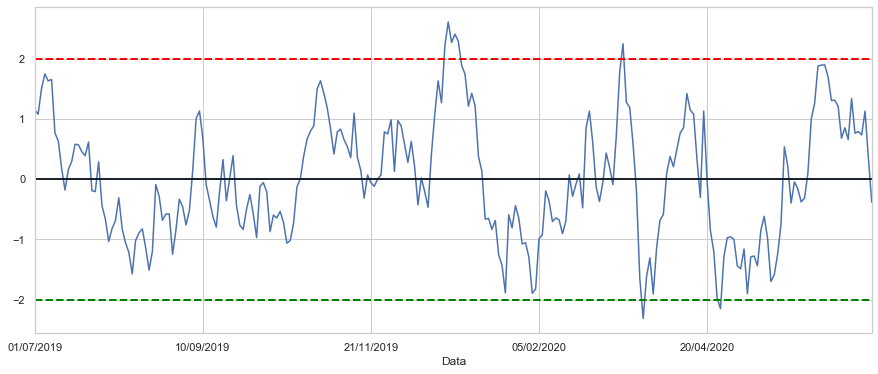

In [432]:
res = resid(data_limmit[y_symbol], data_limmit[x_symbol], coef)
# antes de plotar os dados devem ser invertidos para ordem crescente
ret = zscore(res[::-1])
std = statistics.stdev(ret)
ret.plot(figsize=(15,6))
plt.axhline(ret.mean())

plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(2*std, color='red', linestyle='--', linewidth=2)
plt.axhline(-2*std, color='green', linestyle='--', linewidth=2)

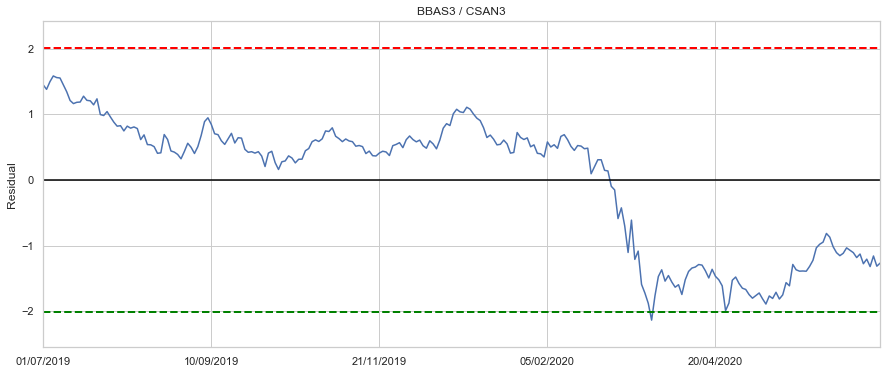

In [242]:
show(data[::-1], y_symbol, x_symbol, period)

In [39]:
model = regression(data, y_symbol, x_symbol, period)
model.params

const   -13.935369
CSAN3     0.635860
temp      0.140448
dtype: float64

In [18]:
"""zscore(model.resid)[::-1].plot(figsize=(15,6))"""

'zscore(model.resid)[::-1].plot(figsize=(15,6))'

In [385]:
"""coef_temp = -0.0003
coef_ang = 0.141
coef_linear = 9.97

#data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear
resid = data_limmit[y_symbol]-coef_ang*data_limmit[x_symbol]-data_limmit['Du']*coef_temp-coef_linear
resid = resid[::-1]"""

"coef_temp = -0.0003\ncoef_ang = 0.141\ncoef_linear = 9.97\n\n#data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear\nresid = data_limmit[y_symbol]-coef_ang*data_limmit[x_symbol]-data_limmit['Du']*coef_temp-coef_linear\nresid = resid[::-1]"